In [86]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'../../../..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import os
from datetime import datetime as dt
import numpy as np
import pandas as pd
import scipy.stats as scist

import matplotlib.pyplot as plt

import tensorflow as tf
from tqdm.notebook import tqdm, trange
import yfinance as yf
import arch
import pmdarima

from analysis.options.pricing.utils import PriceSim
from analysis.options.pricing.garch import Garchcaster

import seaborn as sns; sns.set(style = 'whitegrid')

# Remember The Past #

Up to now we have assumed that each daily draw from a financial time-series is both independent *and* stationary. This is likely not the case.

There is much debate as to exactly how, but it is more likely that return time series are both correlated to [near-term historical returns](http://finance.martinsewell.com/stylized-facts/dependence/) and trend over various timeframes. Mandelbrot's [MultiFractal Model](https://users.math.yale.edu/~bbm3/web_pdfs/Cowles1164.pdf) even incorporates a form of "long memory".

We will show how ARMA models accounting for correlation in the mean and GARCH models accounting for correlation in the volatility can incorporate the Phat distribution.

First, we download the full S&P500 daily time series from YAHOO!. 

Then we find both the simple and log returns. There is much [debate in finance](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1549328) regarding "simple v log" returns. Most arguments in favor of log returns tend to [focus on their Gaussian properties](https://quantivity.wordpress.com/2011/02/21/why-log-returns/). Of course, the Gaussian distribution and attempts to squeeze the world into it are anathema to the study of fat tails.

It is most common to use [log returns](http://www.barigozzi.eu/bertinoro_mb_2014.pdf) in ARMA-GARCH models.

We will explore the utilization of both going forward.

In [3]:
sp = yf.download('^GSPC')
sp_ret = sp.Close.pct_change().dropna()
sp_lret = np.log1p(sp.Close.pct_change().dropna())

[*********************100%***********************]  1 of 1 completed


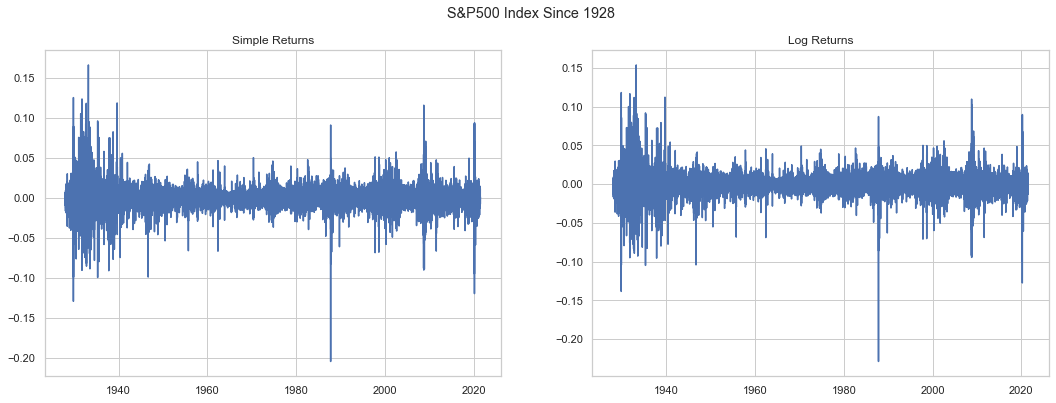

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot(sp_ret)
ax2.plot(sp_lret)

ax1.set_title('Simple Returns')
ax2.set_title('Log Returns')

plt.suptitle('S&P500 Index Since 1928')
plt.show()

### Non-Stationarity ###

Stationarity is a key requirement of ARMA models. In time series, non-stationarity is usually evidenced by some trend, [either via drift from the process itself or a deterministic component of time](https://www.investopedia.com/articles/trading/07/stationary.asp).

The augmented Dickey-Fuller test can be used to detect non-stationarity. The null hypothesis is that the time series is *non-stationary*, so if the test statistic is *lower* than the threshold statistic it can be rejected with that significance.

In [5]:
from statsmodels.tsa.stattools import adfuller

adf, p_value, _, _, crit, _ = adfuller(sp.Close, regression='ct')
adf, crit['10%']

(4.527252357513219, -3.1271602719700304)

Above we see the non-stationary hypothesis cannot be rejected even at just 10% significance-level. Now, we will test for stationarity in the returns.

In [6]:
adf, p_value, _, _, crit, _ = adfuller(sp_ret*100, regression='ct')

In [7]:
adf, crit['1%'], p_value

(-22.578358017226346, -3.959156111408333, 0.0)

The outcome is the complete opposite. The test statistic is well below the 1% threshold and the p-value is zero.

Here we see the value in utilizing returns for financial time-series.

## ARMA ##

There are two approaches to formulating ARMA-GARCH models. One is two-step process that fits the mean process first (ARMA) and then applies GARCH to the residuals. The second fits both the mean and volatility processes simultaneously.

For ARMA-fitting, there are two packages: `statsmodels` and `pmdarima`, with the latter being favored as it has an `auto_arima` function that finds the best model automatically.

For GARCH, the `arch` model is used. `arch` has the ability to AR-GARCH simultaneously, but not any Moving Average (MA) models.

We will first demonstrate the two step process. First, fit the ARMA via `pmdarima` for both simple and log returns.

In [21]:
sparmasim = pmdarima.auto_arima(sp_ret)

In [26]:
sparmasim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                23494
Model:               SARIMAX(0, 0, 2)   Log Likelihood               70625.293
Date:                Wed, 14 Jul 2021   AIC                        -141242.585
Time:                        12:18:03   BIC                        -141210.327
Sample:                             0   HQIC                       -141232.113
                              - 23494                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003   7.78e-05      3.956      0.000       0.000       0.000
ma.L1         -0.0142      0.003     -5.311      0.000      -0.019      -0.009
ma.L2         -0.0171      0.003     -6.530      0.000      -0.022      -0.012
sigma2         0.0001   4.24e-07    337.919      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            301157.97
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
sparmalog = pmdarima.auto_arima(sp_lret)

In [28]:
sparmalog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                23494
Model:               SARIMAX(2, 0, 2)   Log Likelihood               70585.011
Date:                Wed, 14 Jul 2021   AIC                        -141158.022
Time:                        12:19:27   BIC                        -141109.635
Sample:                             0   HQIC                       -141142.314
                              - 23494                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      2.762      0.006    8.12e-05       0.000
ar.L1          0.3526      0.123      2.875      0.004       0.112       0.593
ar.L2         -0.5590      0.100     -5.571      0.000      -0.756      -0.362
ma.L1         -0.3654      0.124     -2.959      0.003      -0.607      -0.123
ma.L2          0.5474      0.102      5.368      0.000       0.348       0.747
sigma2         0.0001    4.1e-07    350.305      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            360184.04
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

So, we can see already the differences in simple and log returns. Simple returns do not even produce an AR model as a best fit (according to `pmdarima`). And it appears to be a slightly better fit than the ARMA(2,2) model found for the log returns.

### Importance of Scale ###

We will see here and later on the importance of appropriate scale for ARMA and GARCH fitting. Share price returns have very small differences that impact the weighting of likelihood models. As a result, returns are often scaled by 100 (showing in percentage terms).

In [8]:
sparmasim100 = pmdarima.ARIMA((2,0,2)).fit(sp_ret*100)

In [9]:
# sparmasim100 = pmdarima.auto_arima(sp_ret*100)

In [10]:
sparmasim100.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                23496
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -37567.723
Date:                Fri, 16 Jul 2021   AIC                          75147.446
Time:                        21:02:58   BIC                          75195.834
Sample:                             0   HQIC                         75163.155
                              - 23496                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0570      0.015      3.852      0.000       0.028       0.086
ar.L1         -0.0213      0.033     -0.636      0.525      -0.087       0.044
ar.L2         -0.8506      0.035    -24.452      0.000      -0.919      -0.782
ma.L1          0.0171      0.035      0.496      0.620      -0.051       0.085
ma.L2          0.8367      0.036     23.303      0.000       0.766       0.907
sigma2         1.4328      0.004    337.623      0.000       1.424       1.441
===================================================================================
Ljung-Box (L1) (Q):                   2.36   Jarque-Bera (JB):            302706.65
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
sparmalog100 = pmdarima.auto_arima(sp_lret*100)

KeyboardInterrupt: 

Above we see two very different models arrived at for both return series. The simple returns now fit to ARMA(2,2) and the log returns fit to ARMA(5,2).

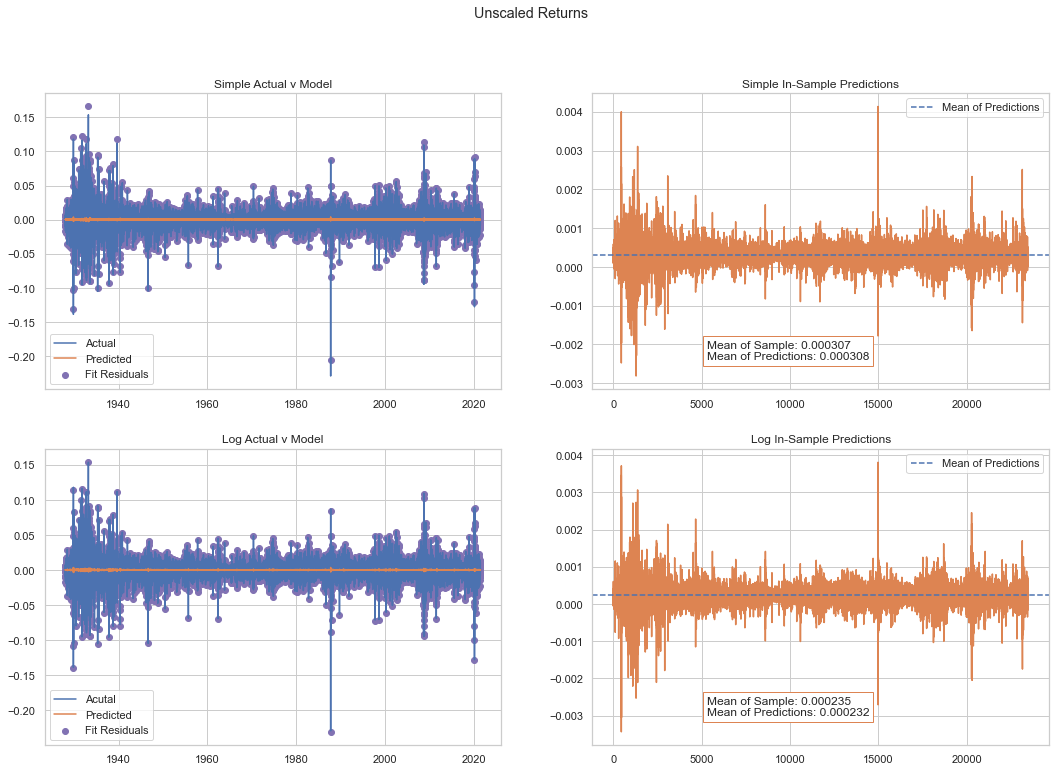

In [80]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))

ax1.plot(sp_lret, label='Actual')

ax1.scatter(sp_lret.index, sparmasim.resid(), c='C4', label='Fit Residuals')
ax1.plot(sp_lret.index, sparmasim.predict_in_sample(), label='Predicted')
ax1.set_title('Simple Actual v Model')

sim_mean = sparmasim.predict_in_sample().mean()
ax2.plot(sparmasim.predict_in_sample(), c='C1')
ax2.axhline(sim_mean, c='C0', ls='--', label='Mean of Predictions')
ax2.set_title('Simple In-Sample Predictions')

ax2text = f'Mean of Sample: {(sp_ret).mean():.6f}'
ax2text += '\n'
ax2text += f'Mean of Predictions: {sim_mean:.6f}'
ax2.text(
    .25,.1, ax2text, 
    transform=ax2.transAxes, ha='left', 
    bbox=dict(facecolor='white', edgecolor='C1')
)

ax3.plot(sp_lret, label='Acutal')
ax3.scatter(sp_lret.index, sparmalog.resid(), c='C4', label='Fit Residuals')
ax3.plot(sp_lret.index, sparmalog.predict_in_sample(), label='Predicted')
ax3.set_title('Log Actual v Model')

log_mean = sparmalog.predict_in_sample().mean()
ax4.plot(sparmalog.predict_in_sample(), c='C1')
ax4.axhline(log_mean, c='C0', ls='--', label='Mean of Predictions')
ax4.set_title('Log In-Sample Predictions')

ax4text = f'Mean of Sample: {(sp_lret).mean():.6f}'
ax4text += '\n'
ax4text += f'Mean of Predictions: {log_mean:.6f}'
ax4.text(
    .25, .1, ax4text, 
    transform=ax4.transAxes, ha='left', 
    bbox=dict(facecolor='white', edgecolor='C1')
)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.suptitle('Unscaled Returns')

plt.show()

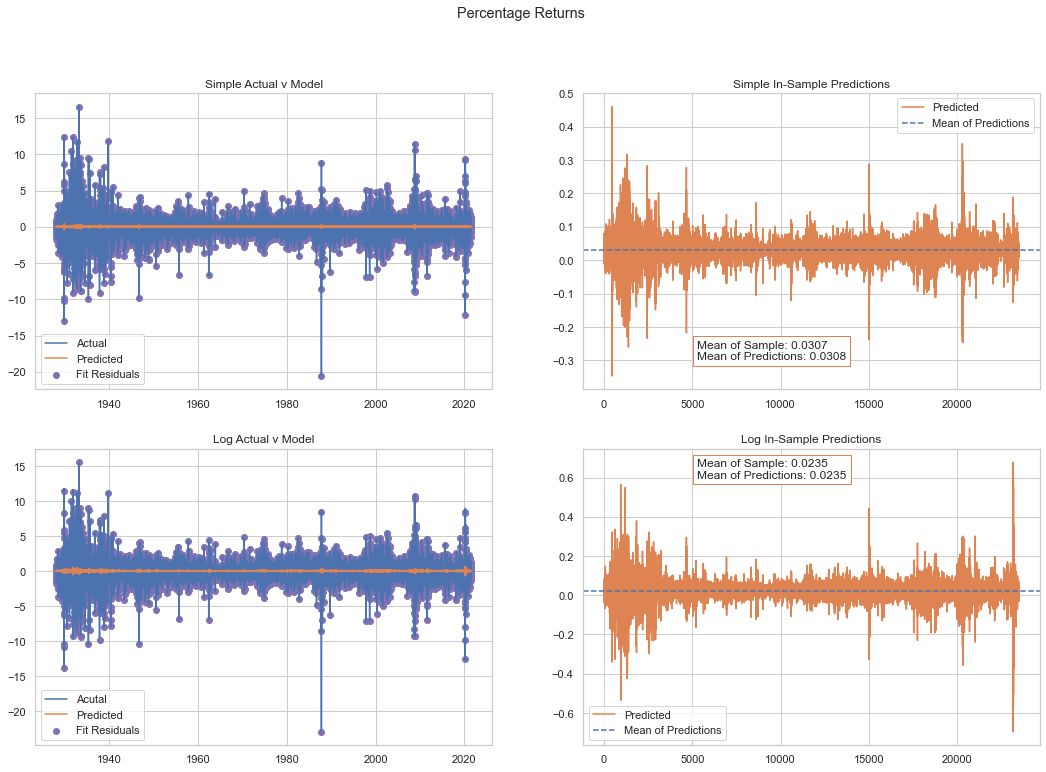

In [76]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))

ax1.plot(sp_ret*100, label='Actual')
ax1.scatter(sp_ret.index, sparmasim100.resid(), c='C4', label='Fit Residuals')
ax1.plot(sp_ret.index, sparmasim100.predict_in_sample(), label='Predicted')
ax1.set_title('Simple Actual v Model')

sim100_mean = sparmasim100.predict_in_sample().mean()
ax2.plot(sparmasim100.predict_in_sample(), c='C1', label='Predicted')
ax2.axhline(sim100_mean, c='C0', ls='--', label='Mean of Predictions')
ax2.set_title('Simple In-Sample Predictions')

ax2text = f'Mean of Sample: {(sp_ret*100).mean():.4f}'
ax2text += '\n'
ax2text += f'Mean of Predictions: {sim100_mean:.4f}'
ax2.text(
    .25,.1, ax2text, 
    transform=ax2.transAxes, ha='left', 
    bbox=dict(facecolor='white', edgecolor='C1')
)

ax3.plot(sp_lret*100, label='Acutal')
ax3.scatter(sp_lret.index, sparmalog100.resid(), c='C4', label='Fit Residuals')
ax3.plot(sp_lret.index, sparmalog100.predict_in_sample(), label='Predicted')
ax3.set_title('Log Actual v Model')

log100_mean = sparmalog100.predict_in_sample().mean()
ax4.plot(sparmalog100.predict_in_sample(), c='C1', label='Predicted')
ax4.axhline(log100_mean, c='C0', ls='--', label='Mean of Predictions')
ax4.set_title('Log In-Sample Predictions')

ax4text = f'Mean of Sample: {(sp_lret*100).mean():.4f}'
ax4text += '\n'
ax4text += f'Mean of Predictions: {log100_mean:.4f}'
ax4.text(
    .25, .9, ax4text, 
    transform=ax4.transAxes, ha='left', 
    bbox=dict(facecolor='white', edgecolor='C1')
)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.suptitle('Percentage Returns')

plt.show()

So what can see from the left-hand charts above is that the ARMA model is generally quite poor at predicting the daily fluctuations in share prices. The residuals are very large and the ARMAs account for only that very thin strip within the actual fluctations.

*However*, on the right-hand charts we can see that the ARMA processes account for *almost all of the mean* of the time series.

Also interesting to note the scaled and unscaled models produce similar mean values even though they utilize different processes and have different residuals.

### GARCH  ###

So, we have a model describing the stationary and dependent mean process of our time-series. The resulting residuals should have a near-zero, constant mean. 

But we can also see this model is very poor at describing returns. So now we look to incorporate volatility dependence via GARCH. This can be done by fitting a GARCH model to the residuals of the ARMA fit. 

We will focus strictly on scaled simple returns.

In [11]:
data = pd.Series(sparmasim100.resid(), index=sp_ret.index)

We use the `arch_model` class from the `arch` package, which defaults to GARCH(1,1).

In [212]:
model = arch.arch_model(data, p=1, q=1)
model_fit = model.fit(disp='off')

We thing we can right away from the fit is the difference in the mean value. We expected a near-zero mean and ended up with a 0.02% mean value. Still relatively small, but noticeably larger than the ARMA fit. By incorporating conditional volatility, we have essentially revealed a larger mean process within the residuals.

In [214]:
model_fit.params.mu, sparmasim100.resid().mean()

(0.022495257188710937, -0.00016483771305546876)

The `model_fit` object can be used to forecast future residual values.

In [229]:
pred = model_fit.forecast(horizon=100, simulations=1, method='simulation', reindex=False)

We can see a single 100-day forecast below, resulting from the small, positive mean and the dynamic variance.

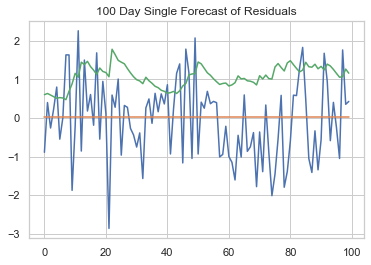

In [230]:
plt.plot(pred.simulations.values[0,0], label='Forecast Values')
plt.plot(pred.mean.iloc[0].values, label='Mean')
plt.plot(pred.variance.iloc[0].values, label='Variance')

plt.title('100 Day Single Forecast of Residuals')

plt.show()

We can show how a forecast compares with actual data, by fitting against a past subset and projecting forward from the last fitted date.

In [239]:
model = arch.arch_model(data[:-100], p=1, q=1)
model_fit = model.fit(disp='off')

GARCH models incorporate a stochastic error term generated from standard normal white noise, i.e. $N(0,1)$, so the value of any single simulation is minimal. Below we show the deviation of four forecasts.

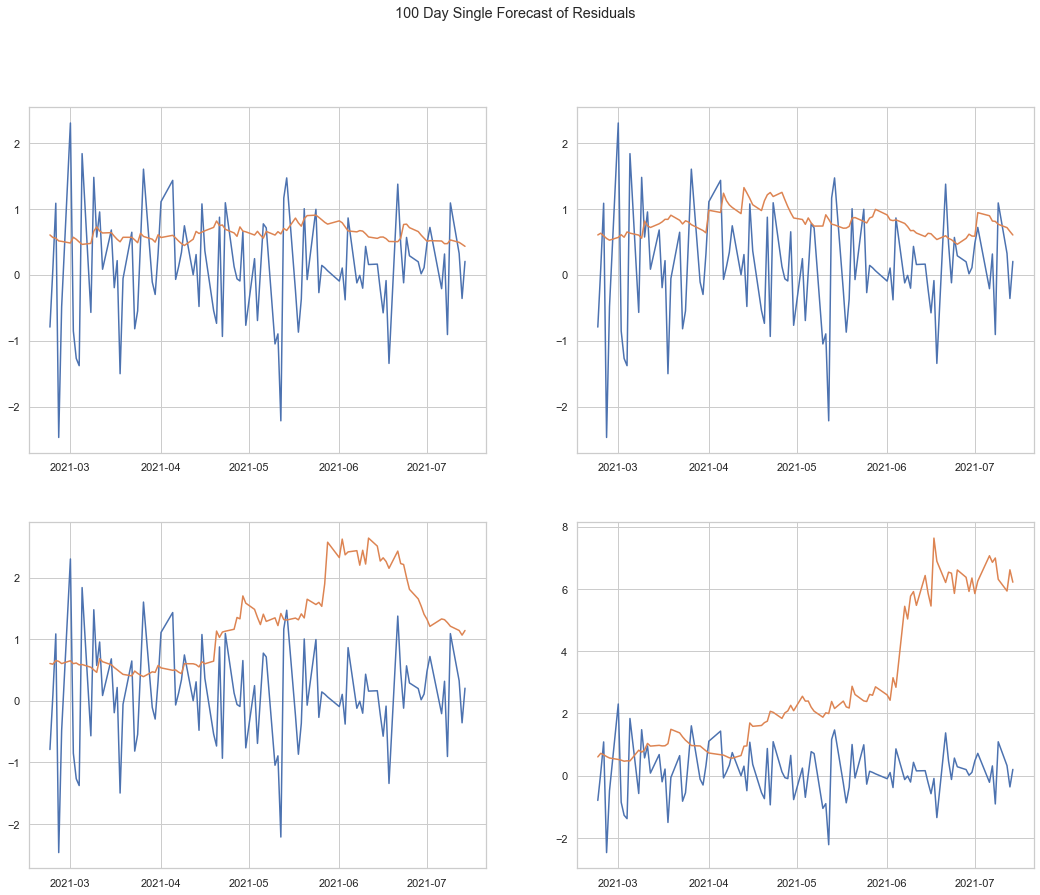

In [241]:
fig, axs = plt.subplots(2,2,figsize=(18,14))

for ax in axs.flatten():
    pred = model_fit.forecast(horizon=100, simulations=1, method='simulation', reindex=False)
    ax.plot(data[-100:])
    ax.plot(data[-100:].index, pred.variance.iloc[0].values, label='Variance')

plt.suptitle('100 Day Single Forecast of Residuals')

plt.show()

#### Projection w Expanding Window ####

We can get a better fit to the actual data if we use a window-process. GARCH models (and all time-series models) can be fit either over the entire time-series or over a window. The intent is to capture any changes in the parameters of the time-series over time. 

An expanding window approach fits the model on an ever-increasing window over a chosen increment. Below we show an expanding window incremented daily.

In [251]:
n = 100
vars_ = np.zeros(n)
means_ = np.zeros(n)
for i in trange(n):
    train = data[:-(n-i)]
    model = arch.arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex=False)
    means_[i] = pred.mean.values[-1][0]
    vars_[i] = np.sqrt(pred.variance.values[-1,:][0])

  0%|          | 0/100 [00:00<?, ?it/s]

We can see below that the forecast variance fits very nicely with the actual. One should also note that the mean value changes slighlty over the 100-day forecast.

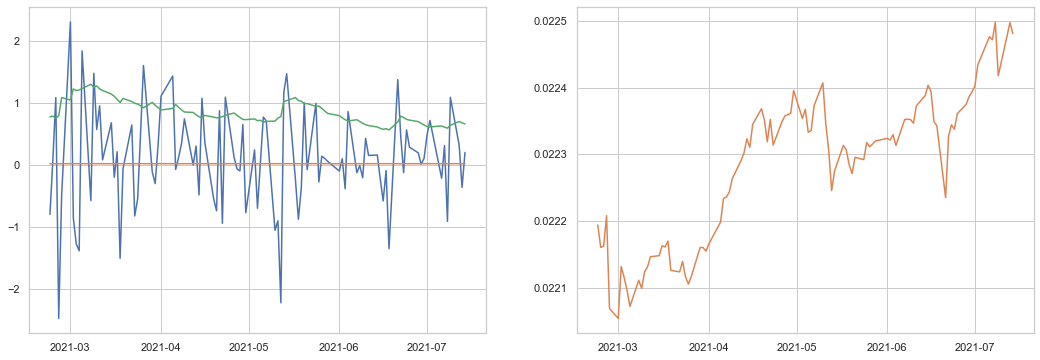

In [252]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot(data[-n:])
ax1.plot(data.index[-n:], means_)
ax1.plot(data.index[-n:], vars_)

ax2.plot(data.index[-n:], means_, c='C1')

plt.show()

We can see this is especially true over a longer time period. Here we increase to 5,000 days.

In [127]:
n = 5000
vars_ = np.zeros(n)
means_ = np.zeros(n)
for i in trange(n):
    train = data[:-(n-i)]
    model = arch.arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex=False)
    means_[i] = pred.mean.values[-1][0]
    vars_[i] = np.sqrt(pred.variance.values[-1,:][0])

  0%|          | 0/5000 [00:00<?, ?it/s]

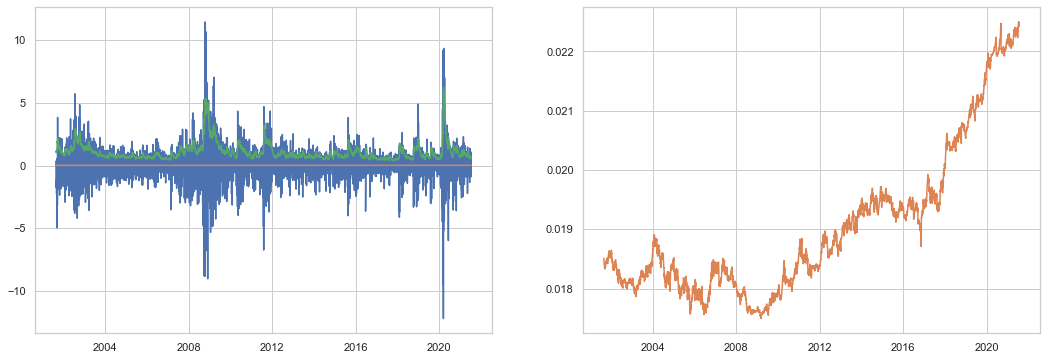

In [129]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6))

ax1.plot(data[-n:])
ax1.plot(data.index[-n:], means_)
ax1.plot(data.index[-n:], vars_)

ax2.plot(data.index[-n:], means_, c='C1')

plt.show()

We can draw a few things from above:

1. ARMA-GARCH models are very good at making short-term forecasts. Beyond 1 to perhaps 10 days, the stochastic error term takes over and drives forecasts in unlikely directions.
2. For long-term forecasting, focus on range forecasts, *not* point forecasts.
3. There is some process unrelated to internal mean or volatility changes that is driving a change in the mean value of returns. Is it an external force? Is it fat tails? Is it pure randomness?

#### Feed Forward for Out-of-Sample Projections ####

Instead of using a multi-horizon forecast via the `forecast` method of `arch`, the forecast can be created by refitting a new model that incorporates the most recent forecast. We will show this process on just the last 20 years of data.

In [276]:
n = 252
window = 5040
foredata = data[-window:].copy()
foredata = np.concatenate((foredata, np.zeros(n)*np.nan))

In [277]:
values = np.zeros(n)
for i in trange(n):
    train = foredata[:-n+i]
    model = arch.arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, simulations=1, method='simulation', reindex=False)
    values[i] = pred.simulations.values[0,0,0]
    foredata[-n+i] = values[i]

  0%|          | 0/252 [00:00<?, ?it/s]

Below we can see the go-forward projection that results. Not a bad result, but it does seem like some of the more extreme values are not replicated.

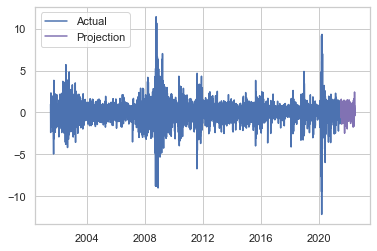

In [279]:
start = data.size - window
x_hist = np.arange(start, start + window)
x_proj = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n, freq='B')

plt.plot(data.iloc[start:], label='Actual')
plt.plot(x_proj, foredata[-n:], c='C4', label='Projection')

plt.legend()

plt.show()

#### Fixed Windows  ####

Instead of an expanding window, a fixed window of observations can be rolled forward. The observations may or may not overlap. This approach more directly captures state changes in the model that may occur over time, although it does also clip information.

First, we show a fixed window on recent data (same as above) incremented forward daily for the last 252 days. This will utilize the same feed-forward forecast used above.

In [280]:
n = 252
window = 5040
foredata = data[-window:].copy()
foredata = np.concatenate((foredata, np.zeros(n)*np.nan))

In [281]:
vars_ = np.zeros(n)
means_ = np.zeros(n)
errs_ = np.zeros(n)
for i in trange(n):
    model = arch.arch_model(foredata[i:-n+i], p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex=False)
    means_[i] = pred.mean.values[-1][0]
    vars_[i] = np.sqrt(pred.variance.values[-1,:][0])
    errs_[i] = np.sqrt(vars_[i])*scist.norm.rvs()
    foredata[window + i] = means_[i] + errs_[i]

  0%|          | 0/252 [00:00<?, ?it/s]

The result is below. Here we see perhaps a bit more variation. This may result from less smoothing through the smaller sample, different properties of the specific window, or it may be from the random error term.

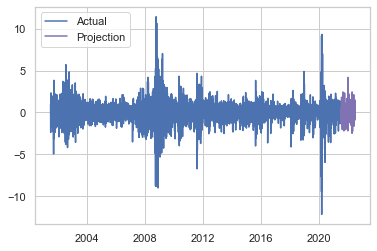

In [282]:
start = data.size - window
x_hist = np.arange(start, start + window)
x_proj = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=n, freq='B')

plt.plot(data.iloc[start:], label='Actual')
plt.plot(x_proj, foredata[-n:], c='C4', label='Projection')

plt.legend()

plt.show()

#### Fixed Window Across Whole Time Series ####

We will expand the above to fit a fixed window across the entire time series. There will be 16 windows. We will drop two years of data with each shift in the window. This results in a window of a bit more than 13 years.

In [12]:
n_windows = 17
drop = 252*5
window = data.size - n_windows*drop

windex = np.array([np.arange(drop*i+1, drop*i + window) for i in range(n_windows + 1)])

In [13]:
vars_ = np.zeros((n_windows+1, window-1))
resids = np.zeros_like(vars_)
for i in trange(n_windows + 1):
    model = arch.arch_model(data[windex[i]], p=1, q=1)
    model_fit = model.fit(disp='off')
    resids[i] = model_fit.std_resid

  0%|          | 0/18 [00:00<?, ?it/s]

Below we show how the conditional volatility fit and the remaining residuals for each observation.

  0%|          | 0/18 [00:00<?, ?it/s]

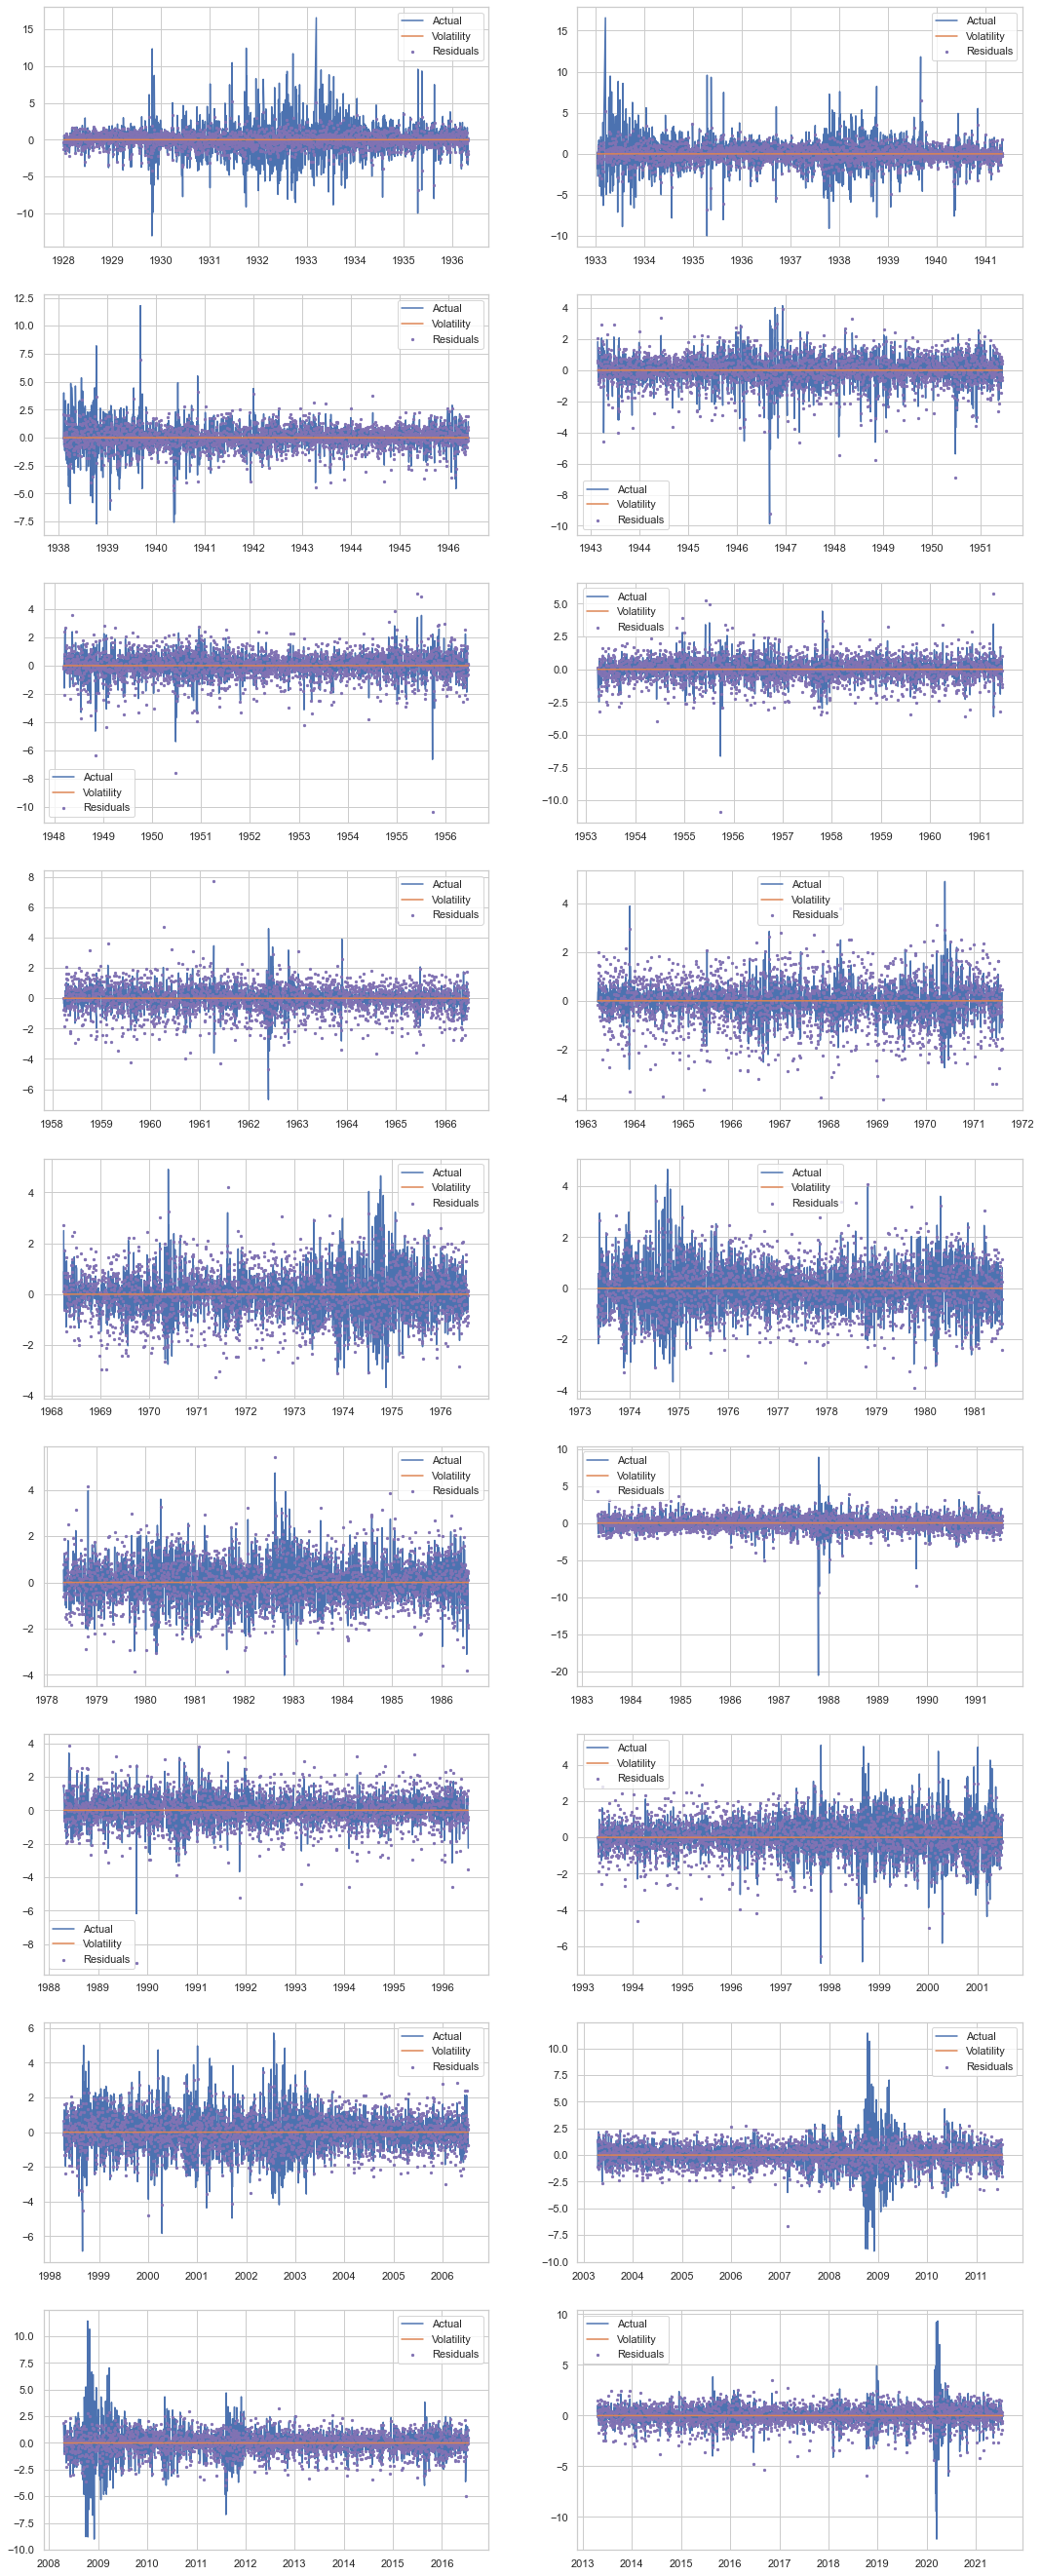

In [14]:
fig, axs = plt.subplots(9,2,figsize=(18,6*8))
axs = axs.flatten()
for i in trange(n_windows+1):
    axs[i].plot(data[windex[i]], label='Actual')
    axs[i].plot(data[windex[i]].index, vars_[i], zorder=3, label='Volatility')    
    axs[i].scatter(data[windex[i]].index, resids[i], c='C4', zorder=3, s=5, label='Residuals')
    
    axs[i].legend()
plt.show()

### Multi-Horizon Forecasts and Price Simulation ###

Forecasting the residuals is helpful but doesn't get us to a full price simulation. To do that, we have to also incorporate the mean process in the ARMA model. In ARMA-GARCH both the mean and variance in the current period are functions of the residual in the prior period. So *both* the ARMA and GARCH must be produce in conjunction at each step in the forecast.

The full ARMA-GARCH system looks as follows:

$$
y_t = \mu_t + \epsilon_t
\\\mu_t = \phi_0 + \sum\limits_{i=1}^m\phi_iy_{t-i} + \sum\limits_{j=1}^n\theta_j\epsilon_{t-j} + \epsilon_t
$$
$$
\\\epsilon_t = e_t\sigma_t
$$
$$
\\\sigma_t^2 = \alpha_0 + \sum\limits_{l=1}^p\beta_l\sigma_{t-l}^2 + \sum\limits_{k=1}^q\alpha_k\epsilon_{t-k}^2
$$

*Note this does not exhaust the bevy of GARCH extensions: HARCH, FIGARCH, GJR-GARCH, etc.*

The `arch` package has a `forecast` method built-in to its results object, however, we developed our own forecasting class to allow for some greater flexibility. See `Garchcaster` under the `garch` module. The class uses **Numba** to speed up processing time.

In [113]:
days = 252
sims = 10000
mod = Garchcaster(
    data.values.copy(), 
    model_fit.conditional_volatility.values.copy(),
    model_fit.resid.values.copy(),
    sparmasim100.params()[:5],
    model_fit.params.values,
    iters=sims,
    periods=days,
)
rets = mod.forecast()

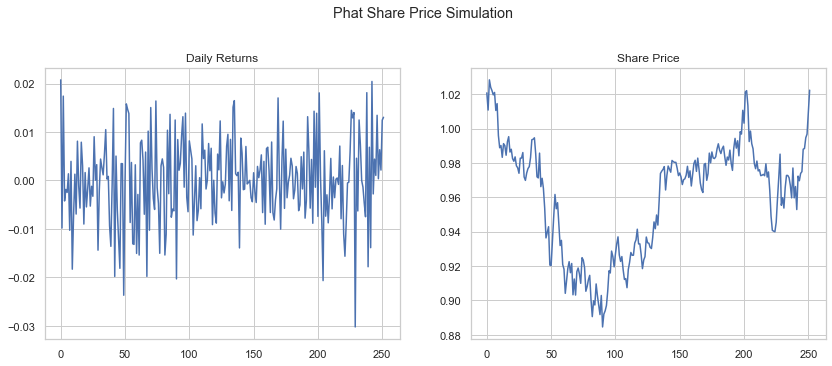

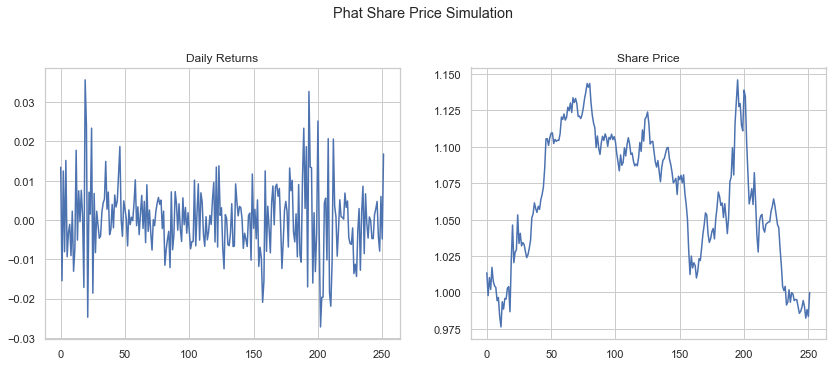

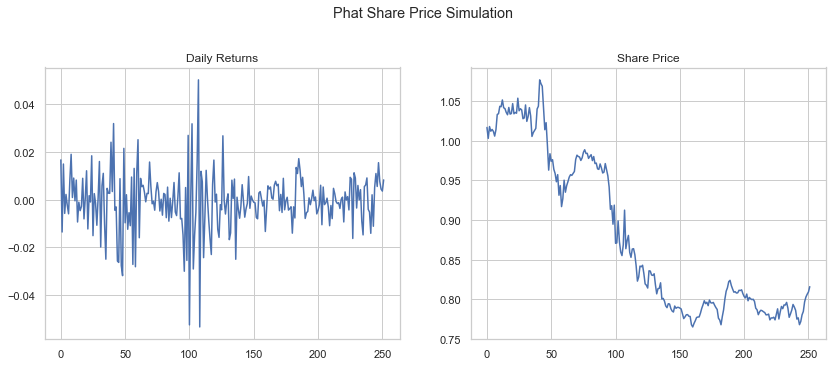

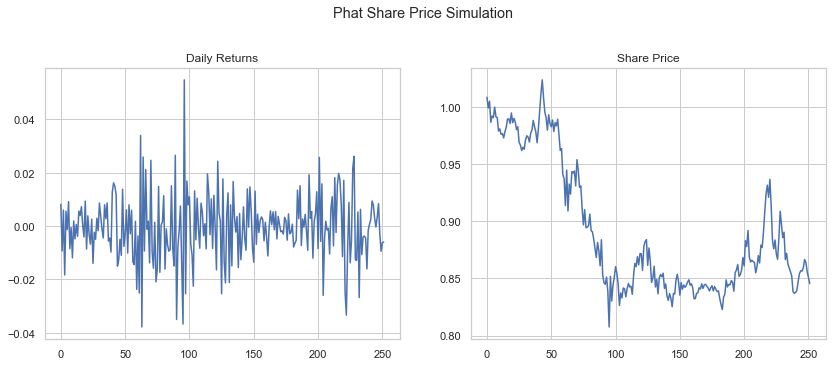

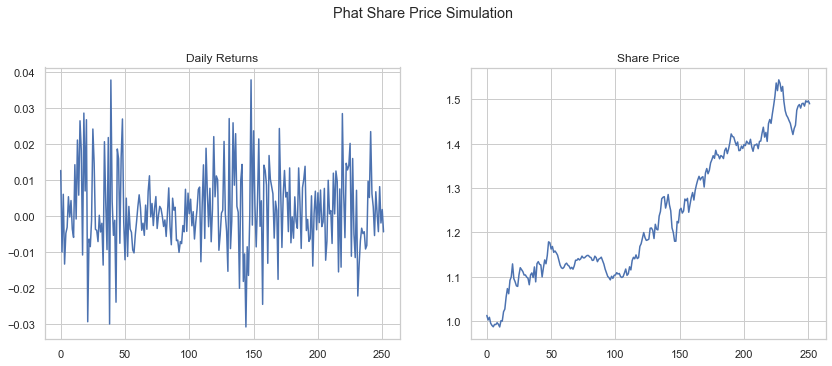

In [114]:
simmer = PriceSim(1, days=days, n=sims)

for i in np.random.randint(0,100, size=5):
    simrets, S, axes = simmer.sim(rets=rets[i]/100+1, show_chart=True)

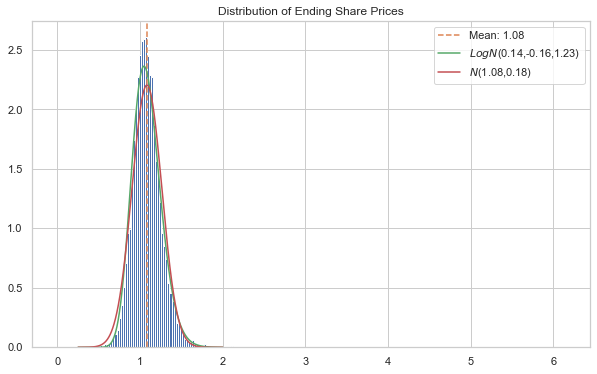

In [115]:
sims_rets, S, (ax, bins) = simmer.sims(rets=rets/100+1, show_chart=True)

ax.axvline(S[:, -1].mean(), c='C1', ls='--', label=f'Mean: {S[:, -1].mean():.2f}')

logps = scist.lognorm.fit(S[:, -1])
x = np.linspace(.25, 2, 1000)
lnormfit = scist.lognorm.pdf(x, *logps)
ax.plot(x, lnormfit, c='C2', label=r'$LogN$'+f'({logps[0]:.2f},{logps[1]:.2f},{logps[2]:.2f})')

ps = scist.norm.fit(S[:, -1])
normfit = scist.norm.pdf(x, *ps)
ax.plot(x, normfit, c='C3', label=r'$N$'+f'({ps[0]:.2f},{ps[1]:.2f})')

ax.legend()
plt.show()

As a check of the validity of the forecasts, we can compare to the same parameter setup from the `arch` `forecast` method. We'll assume a constant mean process derived straight from the GARCH fit from `arch`.

First, we'll show how the average variance at each day of the forecast compares by looking at small samples. We will do just 20 samples, repeated 6 times.

In [116]:
days = 252
sims = 20
mod = Garchcaster(
    data.values.copy(), 
    model_fit.conditional_volatility.values.copy(),
    model_fit.resid.values.copy(),
    None,
    model_fit.params.values,
    iters=sims,
    periods=days,
)

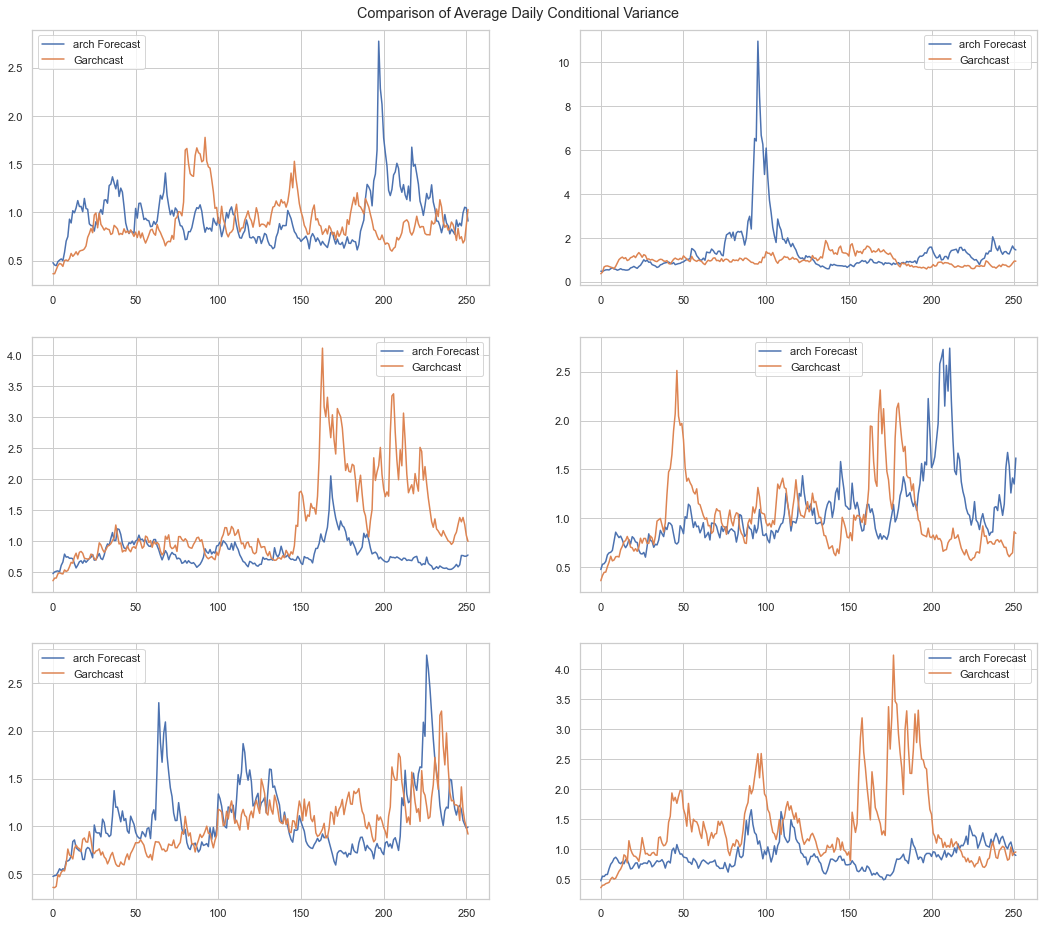

In [117]:
fig, axs = plt.subplots(3,2,figsize=(18,16))

for ax in axs.flatten():
    rets = mod.forecast()
    archsim = model_fit.forecast(horizon=days, simulations=sims, method='simulation', reindex=False)

    ax.plot(archsim.variance.values.T, label='arch Forecast')
    ax.plot((mod.vols**2).mean(axis=0), label='Garchcast')
    ax.legend()

plt.suptitle('Comparison of Average Daily Conditional Variance', y=.9)
plt.show()

The two methods appear to create similar volatility behavior. If we increase to `sims=10000`, we can see that the methods tend towards the same stable value over time.

In [118]:
days = 252
sims = 10000
mod = Garchcaster(
    data.values.copy(), 
    model_fit.conditional_volatility.values.copy(),
    model_fit.resid.values.copy(),
    None,
    model_fit.params.values,
    iters=sims,
    periods=days,
)

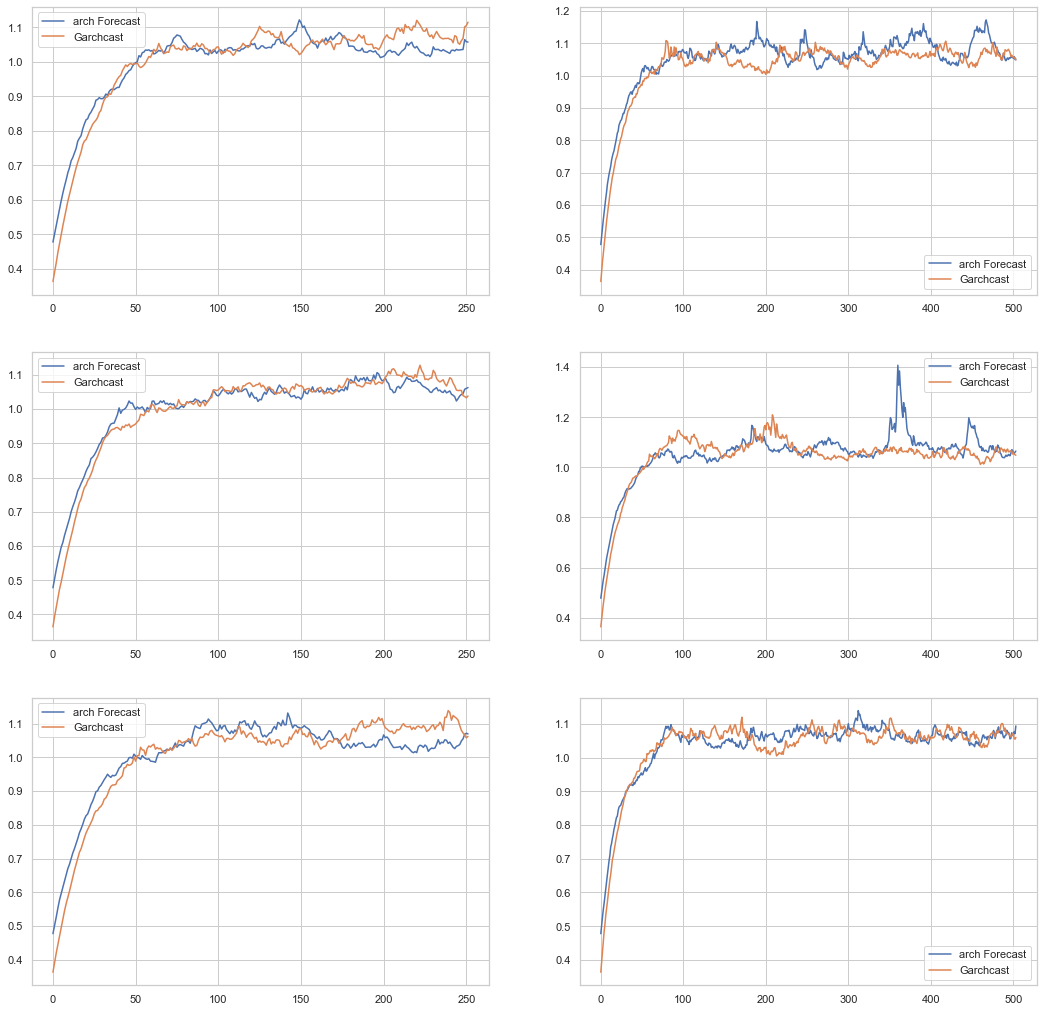

In [119]:
fig, axs = plt.subplots(3,2,figsize=(18,18))

for row in axs:
    for ax, days in zip(row,[252, 504]):
        rets = mod.forecast(periods=days)
        archsim = model_fit.forecast(horizon=days, simulations=sims, method='simulation', reindex=False)    
        ax.plot(archsim.variance.values.T, label='arch Forecast')
        ax.plot((mod.vols**2).mean(axis=0), label='Garchcast')
        ax.legend()
    
plt.show()

Below we can see over 10,000 iterations the the last period price ranges are almost identical.

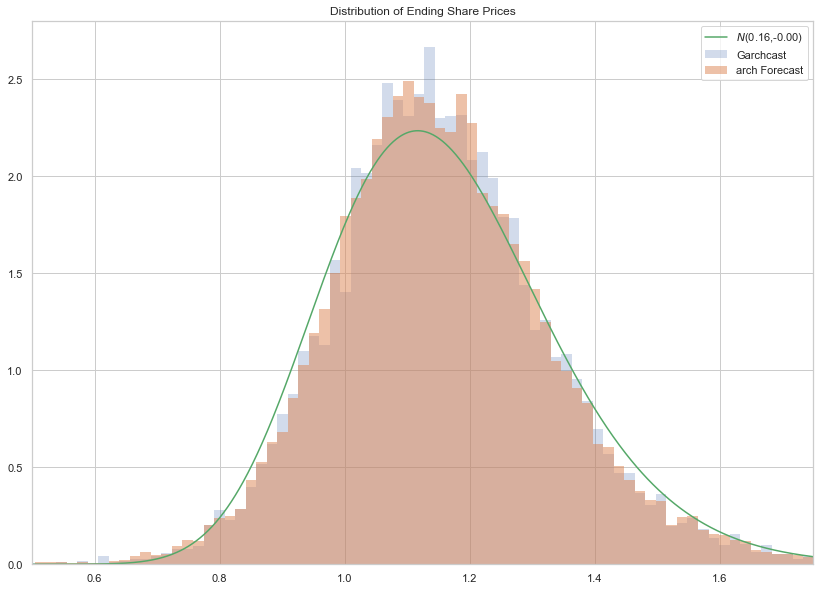

In [120]:
fig, ax = plt.subplots(1,1, figsize=(14,10))

rets = mod.forecast(periods=252)
archsim = model_fit.forecast(horizon=252, simulations=sims, method='simulation', reindex=False)    
sims_rets, S, (ax, bins) = simmer.sims(
    rets=rets/100+1, 
    show_chart=True, 
    ax=ax, lw=0, alpha=.25, label='Garchcast'
)
archsims_rets, archS, (ax, _) = simmer.sims(
    rets=archsim.simulations.values[0]/100+1, 
    show_chart=True, 
    ax=ax, 
    bins=bins, lw=0, alpha=.5, label='arch Forecast'
)
params = scist.lognorm.fit(S[:, -1])
x = np.linspace(.5, 1.75, 1000)
normfit = scist.lognorm.pdf(x,*params)
ax.plot(x, normfit, c='C2', label=r'$N$'+f'({params[0]:.2f},{params[1]:.2f})')

ax.set_xlim(.5,1.75)

ax.legend()
plt.show()

We do a speed comparison below as well:

In [110]:
%timeit rets = mod.forecast(periods=252)

1.45 s ± 35.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [111]:
%timeit archsim = model_fit.forecast(horizon=252, simulations=sims, method='simulation', reindex=False)

476 ms ± 9.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can see the custom forecast in `phattails` is about half as fast. Not great but also not bad given no parallelization and no other attempt to optimize has yet been employed.